In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
traindata=pd.read_pickle("./training.pkl")
testdata1=pd.read_pickle("./testing1.pkl")
testdata2=pd.read_pickle("./testing2.pkl")

In [3]:
stock=traindata[0]

In [4]:
pd.set_option('display.max_rows', None)

Text(0, 0.5, 'Closing Rates')

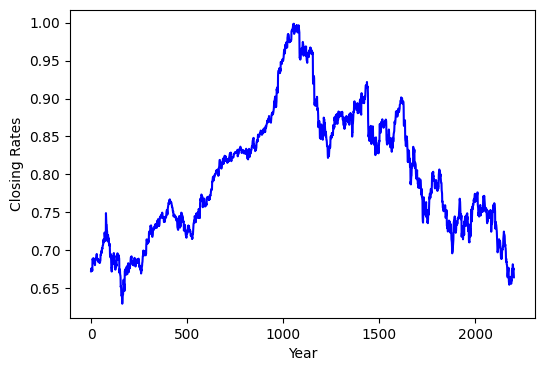

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(traindata[0]['Close'],c='blue')
plt.xlabel("Year")
plt.ylabel("Closing Rates")

In [6]:
data=stock.iloc[:,3]


In [7]:
class dataset(Dataset):
    def __init__(self, data, lookback):
        self.data = data
        self.lookback = lookback
        
    def __len__(self):
        return self.data.shape[0] - self.lookback - 1
    
    def __getitem__(self, idx):
        x, y = self.data[idx : idx+lookback], self.data[idx+1 : idx+lookback+1]
        x = torch.as_tensor(x).float()
        y = torch.as_tensor(y).float()
        return x, y

In [8]:
spt_pct = 0.95
train_data = np.array(data[:int(spt_pct*data.shape[0])]).reshape(-1,1)
test_data =  np.array(data[int(spt_pct*data.shape[0]):]).reshape(-1,1)

In [9]:
lookback =40
batch_size = 20
num_layers = 1
input_dim = 1
hidden_dim = 50
output_dim = 1
dropout=0.2
learning_rate = 0.01
train_set = dataset(train_data, lookback)
test_set = dataset(test_data, lookback)

In [10]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [11]:
class LSTM(nn.Module):
    def __init__(self,input_dim, output_dim, hidden_dim, num_layers,lb):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
       

    def forward(self,x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
      
        # LSTM layer
        out1, _ = self.lstm(x)
        # layer 2
        
        output = self.fc2(out1)
        output = self.relu(output)
        return output

In [12]:
model = LSTM(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers, lb=lookback)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
epochs=70
avgloss=[]
for epoch in range(epochs):
    batchloss=0
    for i, d in enumerate(train_loader):
        optimizer.zero_grad()
        x, t = d
        pred = model(x)
        loss = loss_func(t, pred)
        batchloss+=loss
        loss.backward()
        optimizer.step()
    avgloss.append(batchloss/batch_size)
        

In [14]:
testtarget=[]
testpred=[]
testpred=np.array(testpred).astype(np.float64)
target=np.array(testtarget).astype(np.float64)
for i,(x,t)  in enumerate(test_loader):
    model.eval()
    out=model(x)
    testpred=np.append(testpred,out[:,-1].detach().numpy())
    testtarget=np.append(testtarget, np.array(t[:,-1]))


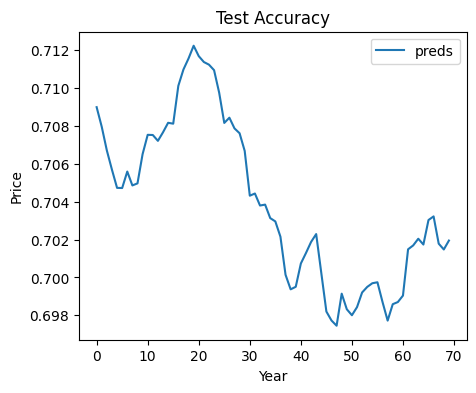

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

plt.plot(testpred, label='preds')
plt.xlabel('Year')
plt.ylabel('Price')

plt.title("Test Accuracy")
plt.legend()
plt.show()

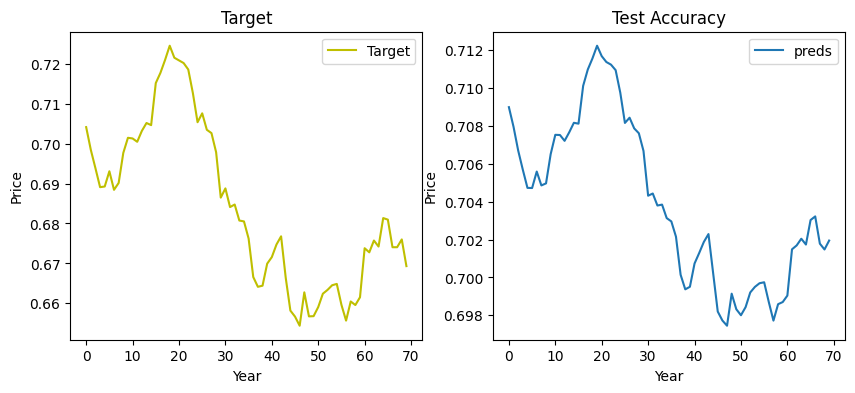

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(testtarget, label= "Target", c='y')
ax[1].plot(testpred, label='preds')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Price')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Price')
ax[0].set_title("Target")
ax[1].set_title("Test Accuracy")
ax[1].autoscale()
ax[0].legend()
ax[1].legend()

In [38]:
predictions= train_data[-lookback:]

for i in range(200):
    inp=torch.as_tensor(predictions[-lookback:],dtype=torch.float32)
    out=model(inp)
    predictions=np.vstack((predictions, out.tolist()[-1]))



In [39]:
preds=np.append(train_data,predictions)
target=np.append(train_data,test_data[:500])


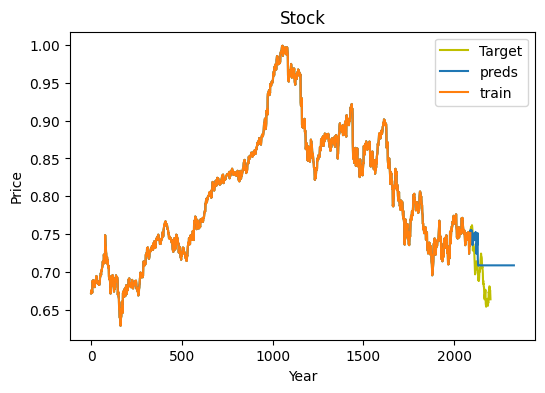

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(target, label= "Target", c='y')
ax.plot(preds, label='preds')
ax.plot(train_data, label='train')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Stock')
plt.legend()
plt.show()

array([0.67196634, 0.67210557, 0.67628222, 0.67349779, 0.6758924 ,
       0.67489   , 0.67294087, 0.6883388 , 0.68861722, 0.68672383])

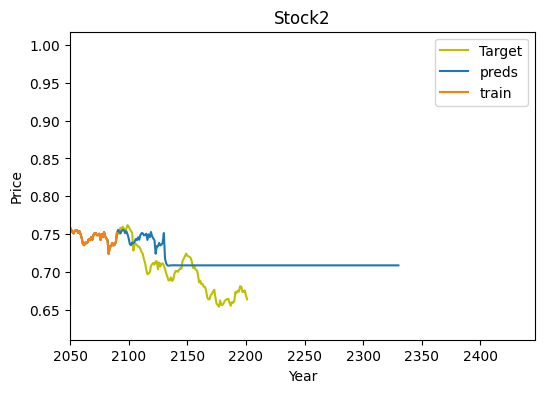

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(target, label= "Target", c='y')
ax.plot(preds, label='preds')
ax.plot(train_data, label='train')
plt.xlim(2050)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Stock2')
plt.legend()
plt.show()